### Importing required libraries

In [26]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

### Setting up library constants

In [27]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


### Importing & Cleaning up database

In [28]:
datapath = 'dataset.tsv'
df = pd.read_csv(datapath, sep='\t')

<Axes: xlabel='count', ylabel='category'>

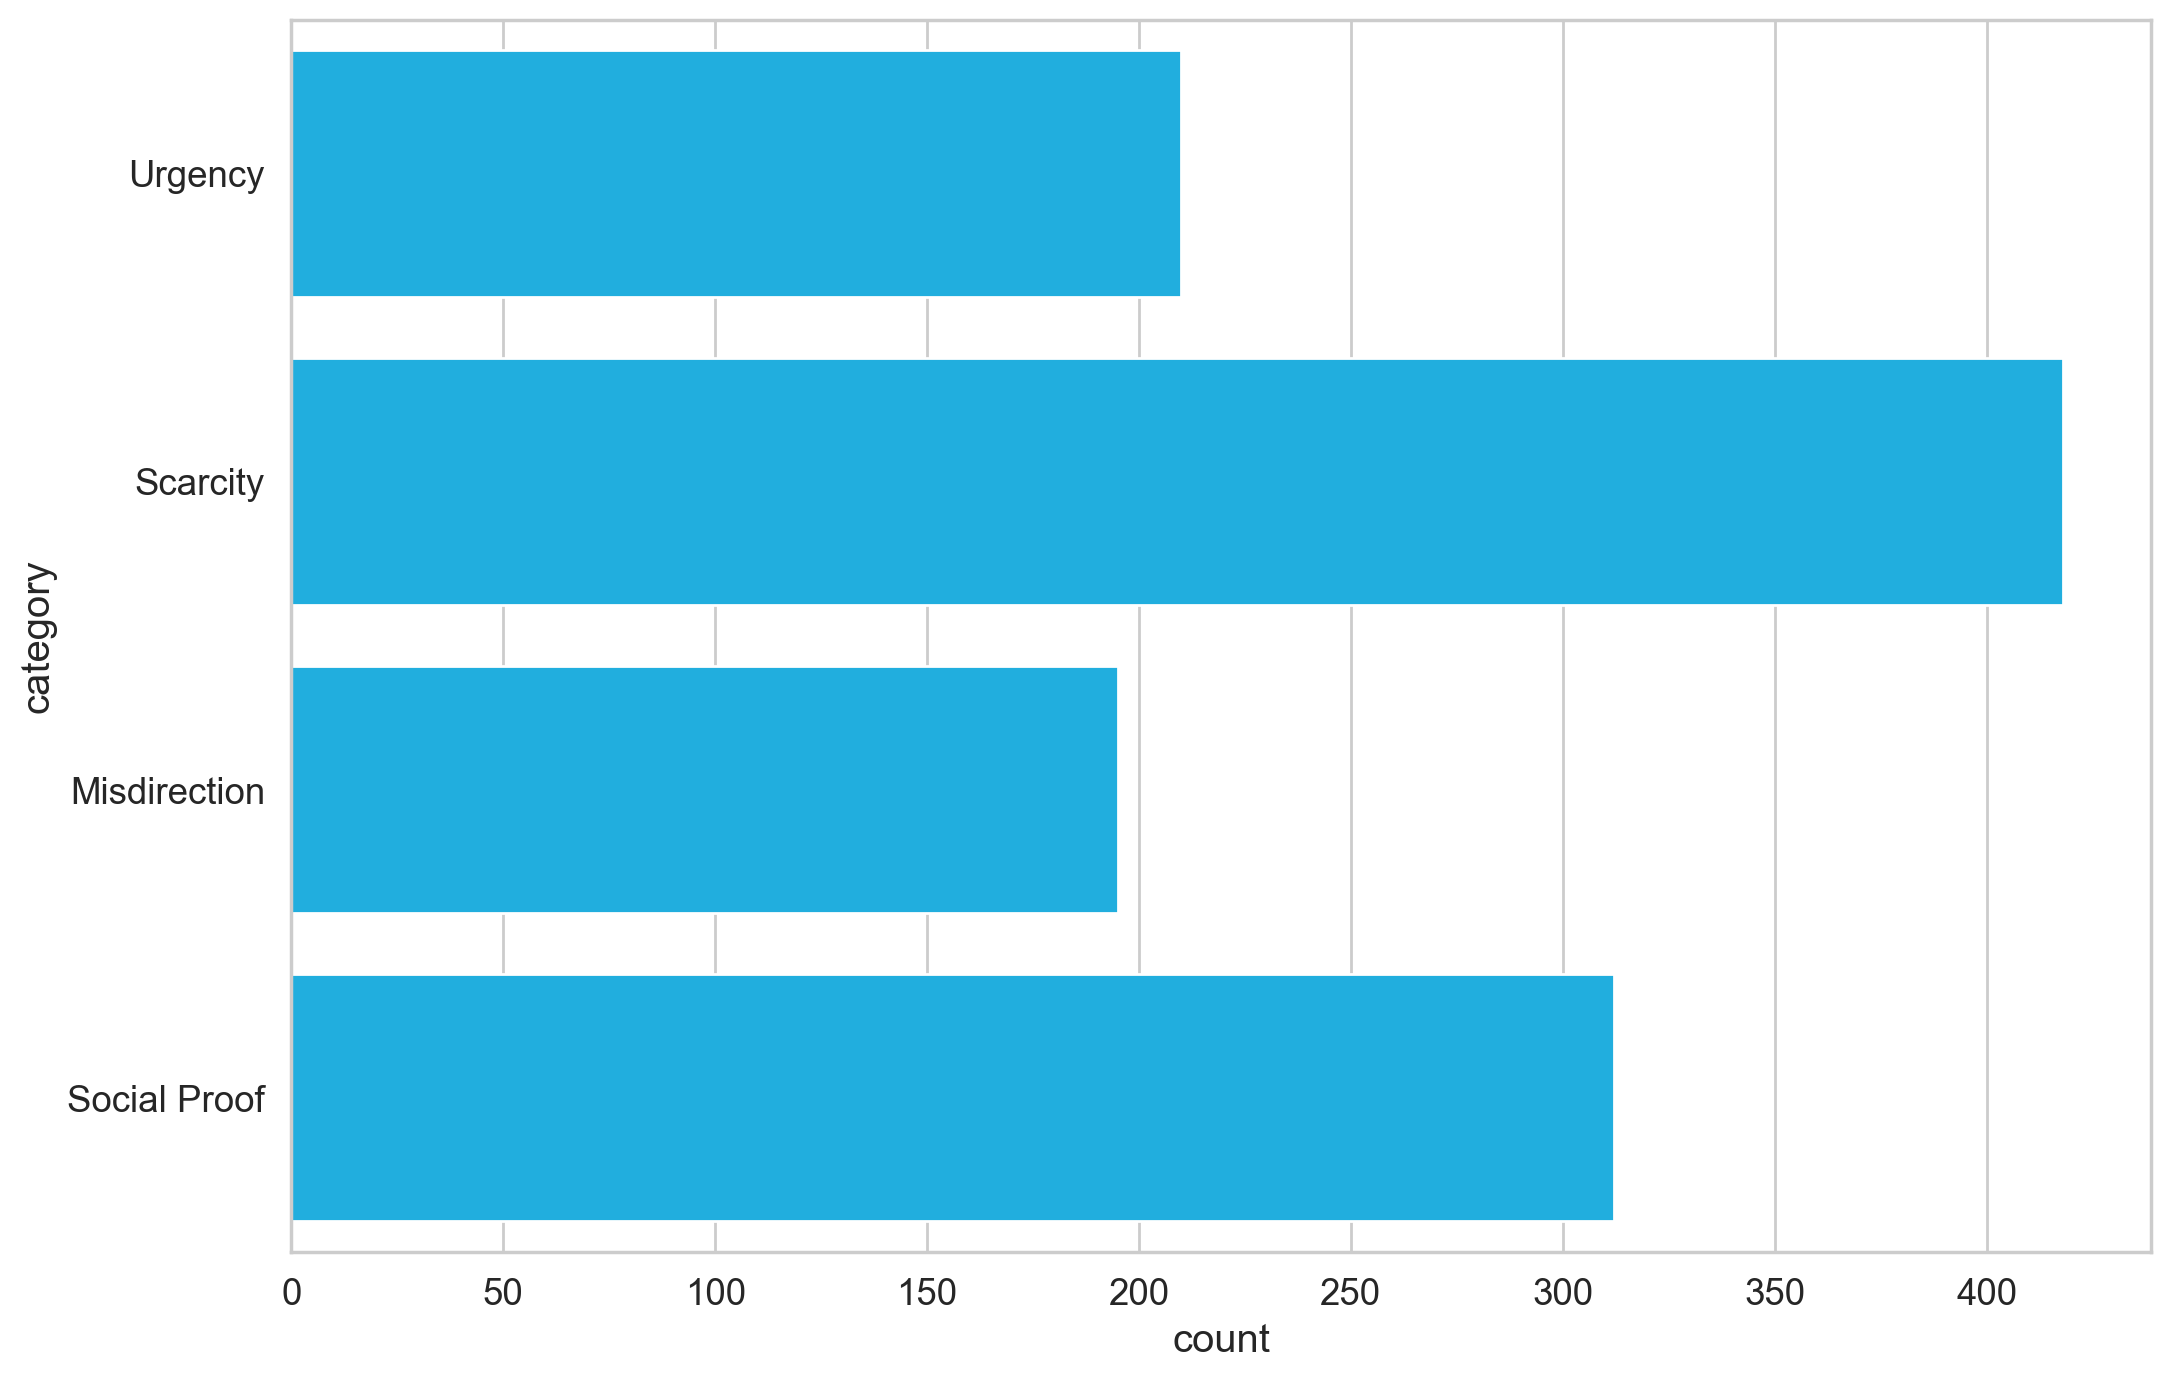

In [63]:

df = df.drop(df[df.category == 'Not Dark Pattern'].index)
df = df.drop(df[df.category == 'Forced Action'].index)
df = df.drop(df[df.category == 'Sneaking'].index)
df = df.drop(df[df.category == 'Obstruction'].index)

sns.countplot(df.category)

In [65]:
labels = {}
for val,key in enumerate(np.unique(df.category)):
    labels[key] = val

class_names = list(labels.keys())

{'Misdirection': 0, 'Scarcity': 1, 'Social Proof': 2, 'Urgency': 3}


### Setting up constants

In [31]:
PRETRAINED = 'bert-base-cased'
BATCHSIZE = 32
TRAIN_RATIO = 0.8
EVAL_RATIO = 0.9
DROPOUT = 0.1
NUM_LABELS = len(class_names)
MODULE_ROOT = os.getcwd()
PROJECT_ROOT = Path(MODULE_ROOT).resolve().parents[1]
PRETRAINED_MODEL_DIR = os.path.join(PROJECT_ROOT, "dark_pattern_spotter\\pretrained_models")
PRETRAINED_MODEL = os.path.join(PRETRAINED_MODEL_DIR, os.listdir(PRETRAINED_MODEL_DIR)[-1])
EPOCHS = 10
LR = 3e-5
MODEL_NAME = "best-model"

### Creating a tokenizer

In [32]:
torch.cuda.empty_cache()
use_cuda = torch.cuda.is_available()
#use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
#device = torch.device('cpu')
print(f"Device: {device}")
tokenizer = BertTokenizer.from_pretrained(PRETRAINED)

Device: cuda


### Selecting max length

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


C:\Users\tanwa\AppData\Local\Temp\ipykernel_16324\323521094.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


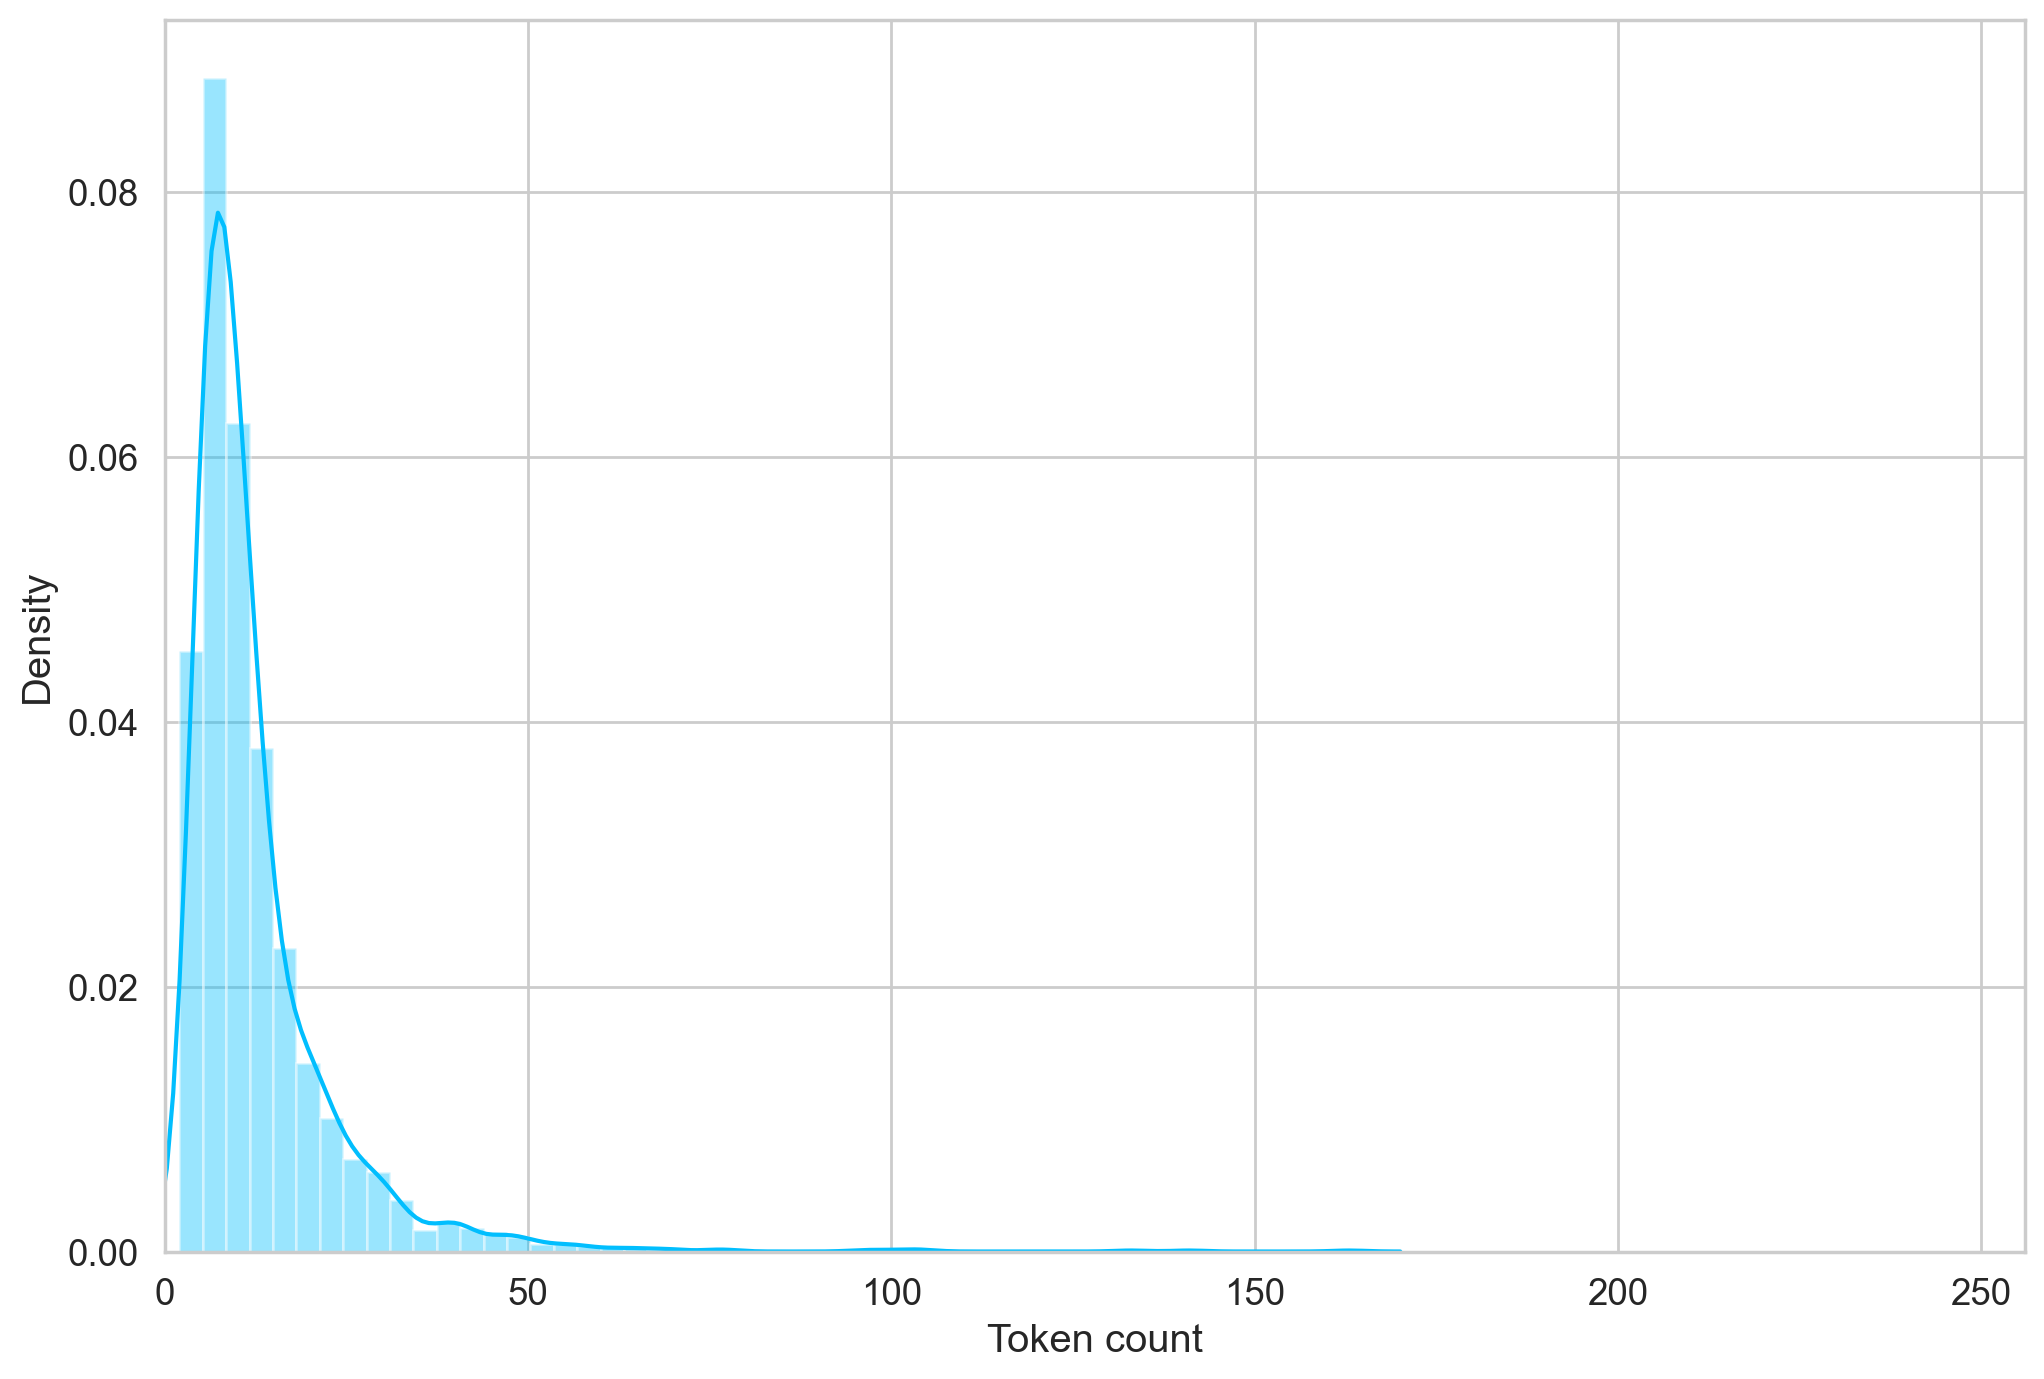

In [33]:

token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

MAXLENGTH = 32

### Creating a dataset consisting of text & labels

In [34]:
class DarkPatternDataset(Dataset):
    def __init__(self, df):
        self.texts = [text for text in df['text']]
        self.targets = [labels[category] for category in df['category']]
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        target = self.targets[idx]

        encoding = tokenizer.encode_plus(text,
                                         add_special_tokens=True,
                                         max_length=MAXLENGTH,
                                         return_token_type_ids=False,
                                         padding='max_length',
                                         return_attention_mask=True,
                                         truncation=True,
                                         return_tensors='pt')
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


### Initialise Dataloaders for training, evaluation and testing

In [35]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_RATIO, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5)


def create_data_loader(df, batch_size):

  ds = DarkPatternDataset(df)

  return DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
  )

train_dataloader = create_data_loader(df_train, BATCHSIZE)
val_dataloader = create_data_loader(df_val, BATCHSIZE)
test_dataloader = create_data_loader(df_test, BATCHSIZE)

### Creating a specialised model for our task

In [36]:
class DarkPatternClassifier(nn.Module):

    def __init__(self, dropout=DROPOUT):
        super(DarkPatternClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRETRAINED)
        self.drop = nn.Dropout(dropout)
        self.out = nn.Linear(self.bert.config.hidden_size, NUM_LABELS)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)
    

### Initialising the model & assigning it to the device

In [37]:
model = DarkPatternClassifier()
model = model.to(device)

### Checking the shape of model's output

In [55]:
data = next(iter(train_dataloader))

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)


torch.Size([32])

### Initialising an `optimizer`, `scheduler` & a `loss_fn`

In [39]:
optimizer = AdamW(model.parameters(), lr=LR, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

c:\Users\tanwa\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Creating a training function

In [40]:
def train_epoch(model, dataloader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(dataloader):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)


### Creating an evaluation function

In [41]:
def eval_model(model, dataloader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in dataloader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


### Importing our pre-trained Dark Pattern Spotter model

In [42]:

checkpoint = torch.load(PRETRAINED_MODEL)
model_dict = model.state_dict() 
pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

### Model training

In [43]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-'*10)

    train_acc, train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_dataloader, loss_fn, device, len(df_val))
    print(f'Val   loss {val_loss} accuracy {val_acc}\n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        model_path = os.path.join(MODULE_ROOT, f"models\\{MODEL_NAME}.pth")
        torch.save(model.state_dict(), model_path)
        best_accuracy = val_acc

Epoch 1/10
----------


  0%|          | 0/58 [00:00<?, ?it/s]

Train loss 0.5112459857723323 accuracy 0.8340540540540541
Val   loss 0.31713987165130675 accuracy 0.9134199134199135

Epoch 2/10
----------


  0%|          | 0/58 [00:00<?, ?it/s]

Train loss 0.14135564483926985 accuracy 0.9610810810810811
Val   loss 0.28966334369033575 accuracy 0.9307359307359307

Epoch 3/10
----------


  0%|          | 0/58 [00:00<?, ?it/s]

Train loss 0.07100041540829337 accuracy 0.9789189189189189
Val   loss 0.32861827965825796 accuracy 0.9393939393939394

Epoch 4/10
----------


  0%|          | 0/58 [00:00<?, ?it/s]

Train loss 0.03105525935474173 accuracy 0.9918918918918919
Val   loss 0.3912967977958033 accuracy 0.9523809523809523

Epoch 5/10
----------


  0%|          | 0/58 [00:00<?, ?it/s]

Train loss 0.015835760583787963 accuracy 0.9967567567567568
Val   loss 0.32900811395666096 accuracy 0.9523809523809523

Epoch 6/10
----------


  0%|          | 0/58 [00:00<?, ?it/s]

Train loss 0.005009724537777747 accuracy 0.9989189189189189
Val   loss 0.23383970389841124 accuracy 0.9567099567099567

Epoch 7/10
----------


  0%|          | 0/58 [00:00<?, ?it/s]

Train loss 0.0015397418123782322 accuracy 0.9994594594594595
Val   loss 0.23644836365565425 accuracy 0.9437229437229437

Epoch 8/10
----------


  0%|          | 0/58 [00:00<?, ?it/s]

Train loss 0.0012534334166738172 accuracy 0.9994594594594595
Val   loss 0.24384085502970265 accuracy 0.9437229437229437

Epoch 9/10
----------


  0%|          | 0/58 [00:00<?, ?it/s]

Train loss 0.0008485057338036533 accuracy 1.0
Val   loss 0.2795473684091121 accuracy 0.9437229437229437

Epoch 10/10
----------


  0%|          | 0/58 [00:00<?, ?it/s]

Train loss 0.0006641739209640193 accuracy 1.0
Val   loss 0.37188589059223887 accuracy 0.9437229437229437

CPU times: total: 49.5 s
Wall time: 5min 21s


### Training analytics

In [44]:
history['train_acc'] = [x.cpu() for x in history['train_acc']]
history['val_acc'] = [x.cpu() for x in history['val_acc']]

(0.0, 1.0)

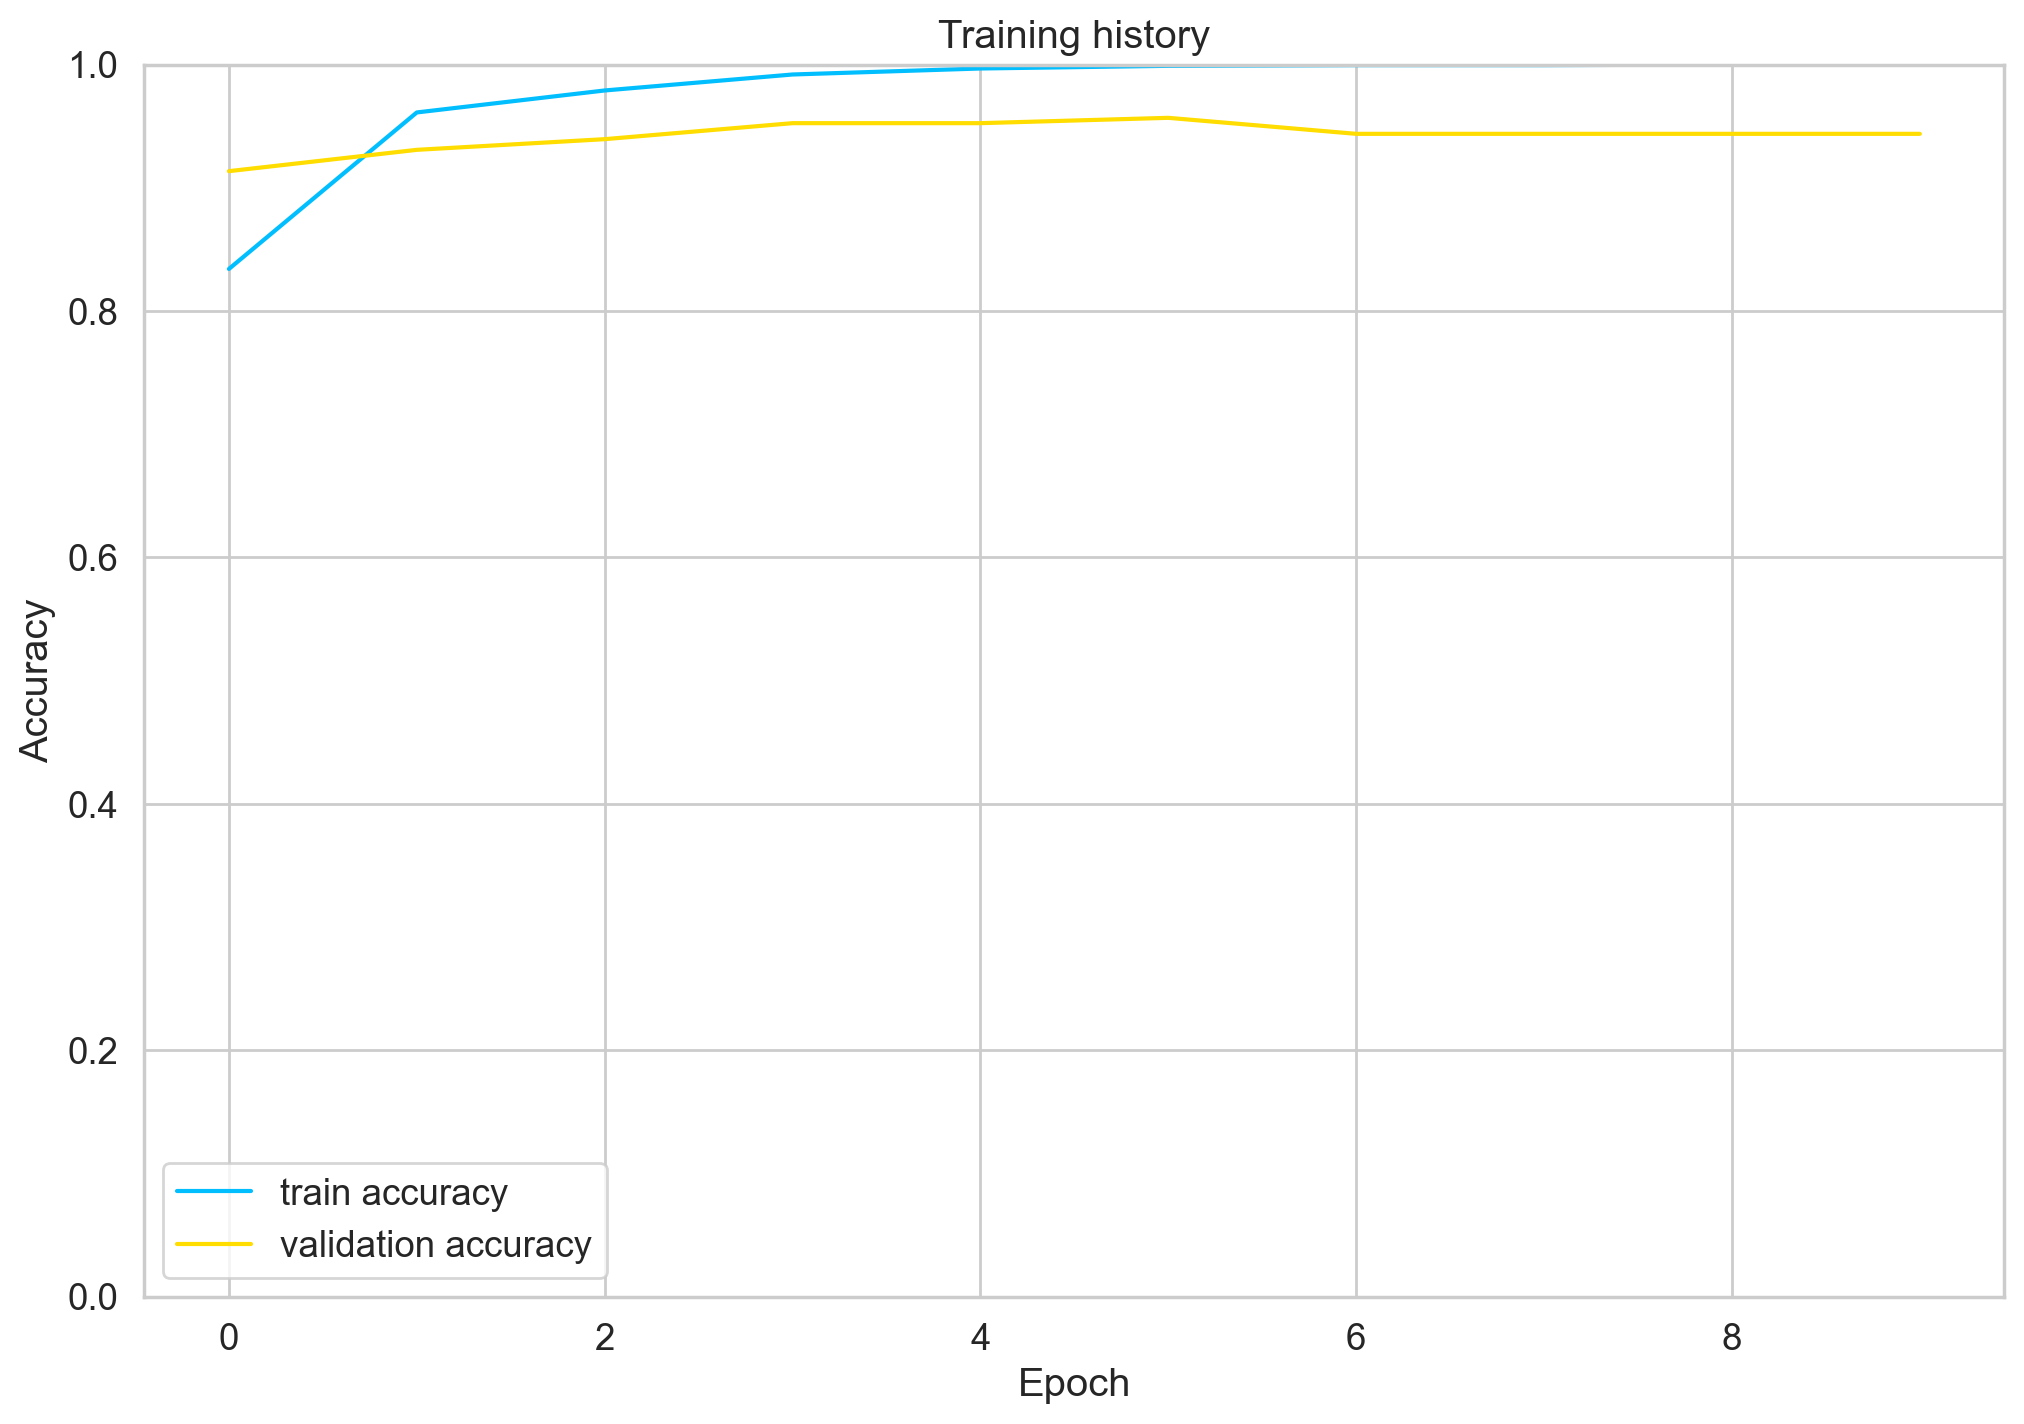

In [45]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

### Model evaluation

In [46]:
test_acc, _ = eval_model(model, test_dataloader, loss_fn, device, len(df_test))

test_acc.item()

0.9698275862068966

### A helper function to get more analytics

In [47]:
def get_predictions(model, dataloader):
    model = model.eval()

    texts = []
    predictions = []
    predictions_probs = []
    real_vals = []

    with torch.no_grad():
        for d in dataloader:
            text = d["text"]
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            texts.extend(text)
            predictions.extend(preds)
            predictions_probs.extend(outputs)
            real_vals.extend(targets)
    
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_vals = torch.stack(real_vals).cpu()

    return texts, predictions, predictions_probs, real_vals

### Model accuracy

In [48]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_dataloader)

In [49]:
# One might need to remove categories with low frequencies in the dataset
# because there might not be any results with said category in the test dataset

#class_names.remove("Forced Action")

print(classification_report(y_test, y_pred, target_names=class_names))

                  precision    recall  f1-score   support

    Misdirection       0.88      0.94      0.91        16
Not Dark Pattern       0.97      0.97      0.97       112
        Scarcity       0.96      0.98      0.97        44
    Social Proof       1.00      1.00      1.00        35
         Urgency       1.00      0.92      0.96        25

        accuracy                           0.97       232
       macro avg       0.96      0.96      0.96       232
    weighted avg       0.97      0.97      0.97       232



### Generating a confusion matrix

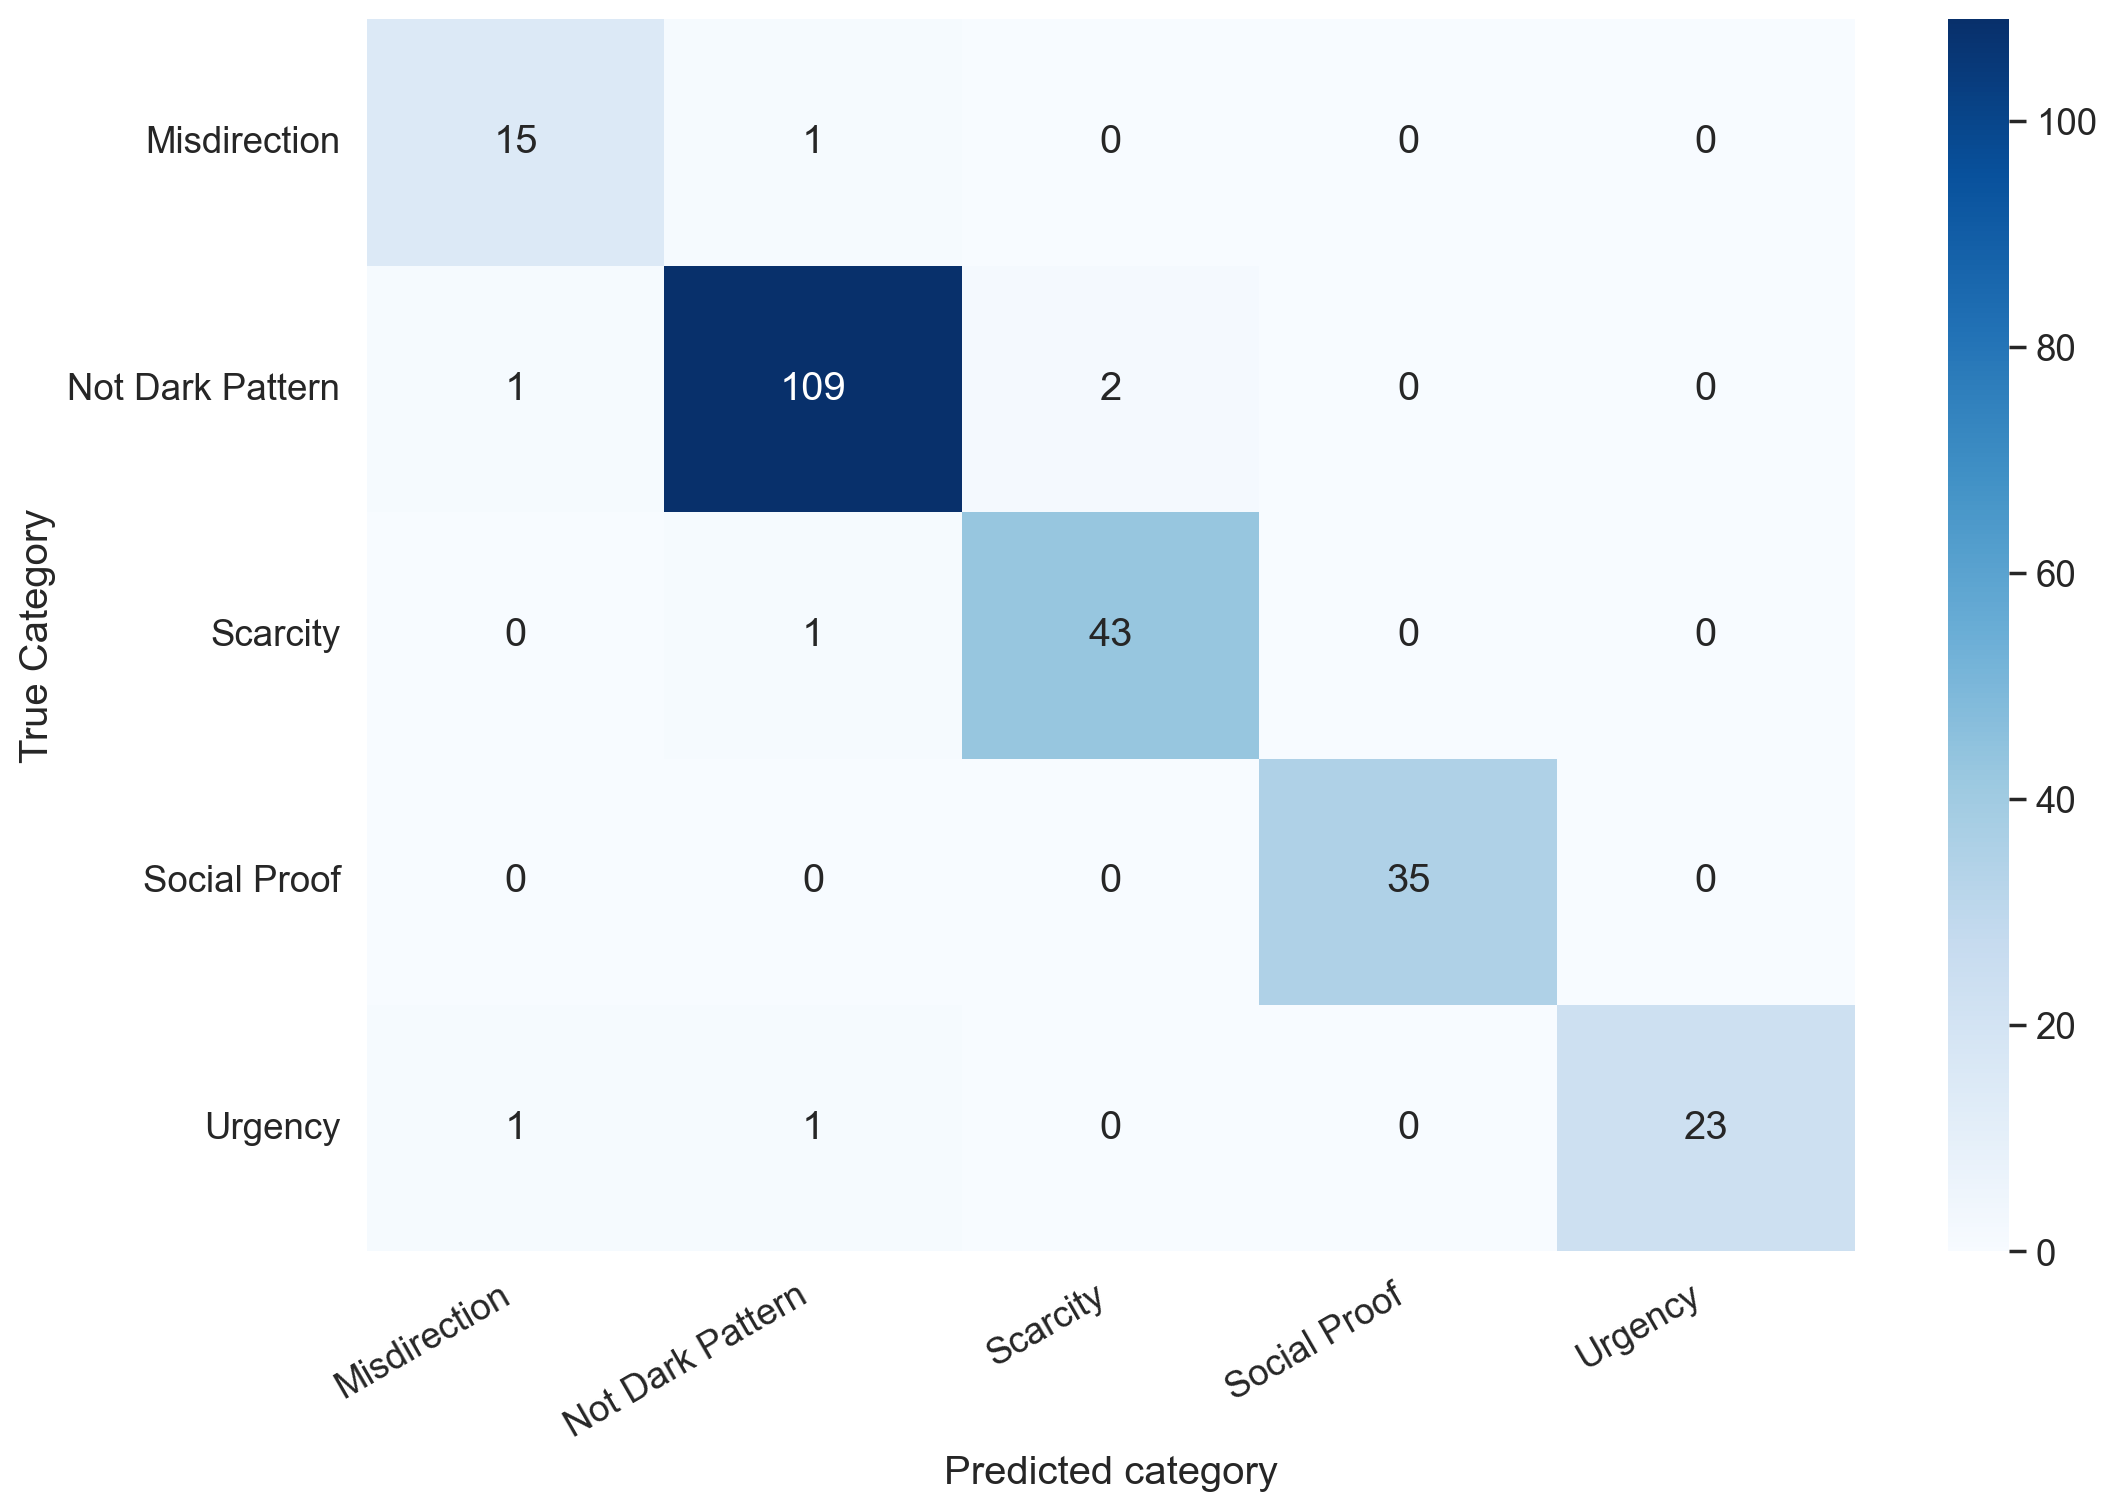

In [50]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Category')
    plt.xlabel('Predicted category')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Running model on raw text

In [86]:
someText = "Some sample text"
encoded = tokenizer.encode_plus(
        someText,
        add_special_tokens=True,
        max_length=MAXLENGTH,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt')

input_ids = encoded['input_ids'].to(device)
attention_mask = encoded['attention_mask'].to(device)

output = model(input_ids, attention_mask)
print(torch.max(output, dim=1))

torch.return_types.max(
values=tensor([8.2496], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))
